In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import io, linalg, stats, ndimage, signal
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':12})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})
# rc('text', usetex=False)

In [4]:
import ladyns as ldn
import ladyns.inference as inf

# 1. simulate data

In [5]:
np.random.seed(12345)

In [6]:
dims = [25, 25]
num_rtime = 500
num_trial = 1000

In [7]:
coords_S = [np.array(np.where(np.full((5,5), True))).T for _ in np.arange(2)]
sigmas_S = [0.8, 0.8]
covs_S = [np.exp(-np.sum((cd[:,None,:] - cd[None,:,:])**2,-1)
                 / (2 * sigma**2))
          for cd, sigma in zip(coords_S, sigmas_S)]

## background pink noise

In [8]:
alpha = 1.4
f = np.linspace(0, np.pi, num_rtime//2+1)[1:-1]
psd = 1/(f**alpha)

In [9]:
Ws = [np.sqrt(0.5 * psd)[:,None] * 
      np.random.multivariate_normal(np.zeros(d), cov, 
            size=(num_trial, num_rtime//2-1))
      for d, cov in zip(dims, covs_S)]
RZs = [np.concatenate([
        np.random.multivariate_normal(np.zeros(d), cov, size=(num_trial,1)), 
        W, 
        np.random.multivariate_normal(np.zeros(d), cov, size=(num_trial,1)), 
        np.flip(W, axis=1)], axis=1)
       for d, W, cov in zip(dims, Ws, covs_S)]

In [10]:
Ws = [np.sqrt(0.5 * psd)[:,None] * 
      np.random.multivariate_normal(np.zeros(d), cov, 
            size=(num_trial, num_rtime//2-1))
      for d, cov in zip(dims, covs_S)]
IZs = [np.concatenate([
        np.zeros((num_trial,1,d)), 
        W, 
        np.zeros((num_trial,1,d)), 
        np.flip(W, axis=1)], axis=1)
       for W, cov, d in zip(Ws, covs_S, dims)]

In [11]:
Ws[0].shape

(1000, 249, 25)

In [12]:
etas = [np.fft.irfft(RZ+ 1j*IZ, num_rtime, axis=1)
        for RZ, IZ in zip(RZs, IZs)]

In [13]:
etas

[array([[[ 0.05760819,  0.05861381,  0.17010278, ...,  0.01338145,
           0.10874906,  0.23966066],
         [ 0.00483715,  0.0487819 ,  0.17754886, ..., -0.02851451,
           0.07764308,  0.24802771],
         [-0.08084993,  0.02159035,  0.13535519, ...,  0.08793985,
           0.05801628,  0.22296644],
         ...,
         [-0.02164378, -0.00409419,  0.08428535, ...,  0.07262078,
           0.07610566,  0.16202685],
         [-0.09019884, -0.03280185,  0.12966923, ...,  0.06471091,
           0.06332688,  0.13883073],
         [-0.00246384,  0.03759567,  0.1529114 , ...,  0.04513392,
           0.11342398,  0.1807792 ]],
 
        [[ 0.04158268,  0.04307332,  0.0208303 , ..., -0.19345887,
          -0.06471672,  0.05829142],
         [ 0.05519318,  0.11723474,  0.06383683, ..., -0.13655684,
          -0.03038083,  0.08067704],
         [ 0.04507273,  0.12653803,  0.03501542, ..., -0.07807629,
          -0.03495001,  0.09128007],
         ...,
         [ 0.08358584,  0.1157321

In [14]:
cwt_omega = 3
cwt_scales = cwt_omega * 1000 / (2 * (np.arange(100)+1) * np.pi)

In [15]:
cwt_eta_0 = [np.zeros((d, len(cwt_scales), num_rtime), dtype=np.complex128)
             for d in dims]
for k, d in enumerate(dims):
    for i in np.arange(d):
        cwt_eta_0[k][i] = signal.cwt(etas[k][0,:,i], signal.morlet2, cwt_scales, w=cwt_omega)

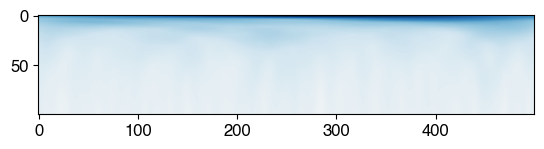

In [16]:
ldn.imshow(np.mean(np.abs(cwt_eta_0[0]),0))

In [17]:
cwt_eta = np.zeros((num_trial, len(cwt_scales), num_rtime), dtype=np.complex128)
for i in np.arange(1000):
    cwt_eta[i] = signal.cwt(etas[0][i,:,0], signal.morlet2, cwt_scales, w=cwt_omega)

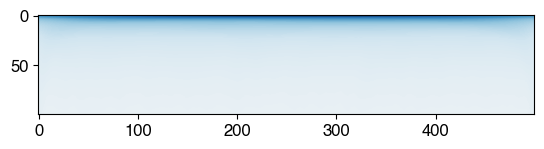

In [18]:
ldn.imshow(np.mean(np.abs(cwt_eta),0))

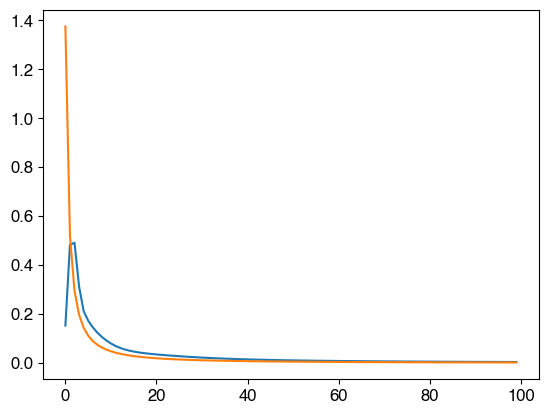

In [19]:
plt.plot(np.mean(np.abs(cwt_eta_0[0])**2, axis=(0,-1)))
plt.plot(0.003 * psd[:100])

## beta band signal

In [20]:
f_beta = 18
ts_sig = [80, 200, 400]
ss_sig = [5000/4, 5000/4, 5000/4]
pbts = [np.exp(-np.square(np.arange(num_rtime) - t)/s)
       for t, s in zip(ts_sig, ss_sig)]

In [21]:
Ws = [np.random.normal(scale=pbt, size=(num_trial,num_rtime))
      for pbt in pbts]

In [22]:
cwt_omega = 3
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)

In [23]:
beta_map = signal.morlet2(num_rtime, w=cwt_omega, s=cwt_scale)

In [24]:
sigs =  [np.real(signal.convolve(W, beta_map[None,:]))
        for W in Ws]

### plots

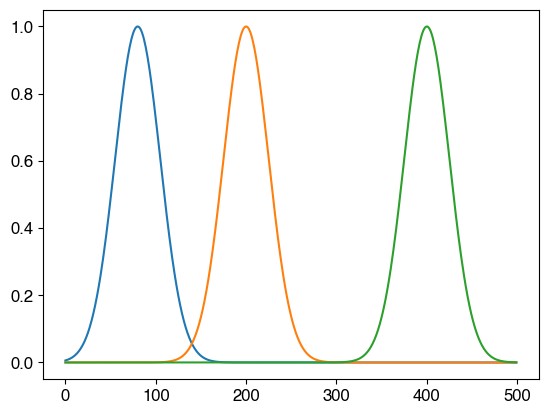

In [25]:
plt.plot(pbts[0])
plt.plot(pbts[1])
plt.plot(pbts[2])

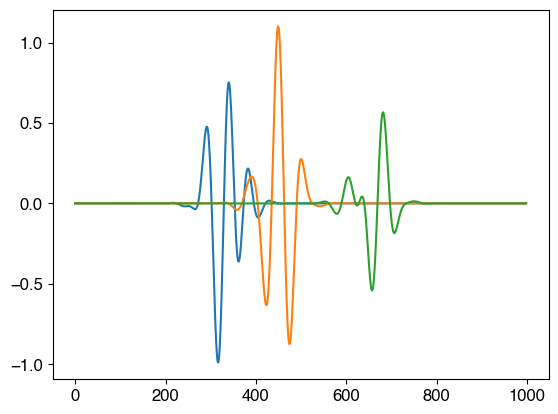

In [26]:
plt.plot(sigs[0][0])
plt.plot(sigs[1][0])
plt.plot(sigs[2][0])

In [27]:
cwt_omega = 3
cwt_scales = cwt_omega * 1000 / (2 * (np.arange(100)+1) * np.pi)

In [28]:
cwts_sig = [signal.cwt(sig[0], signal.morlet2, cwt_scales, w=cwt_omega)
           for sig in sigs]

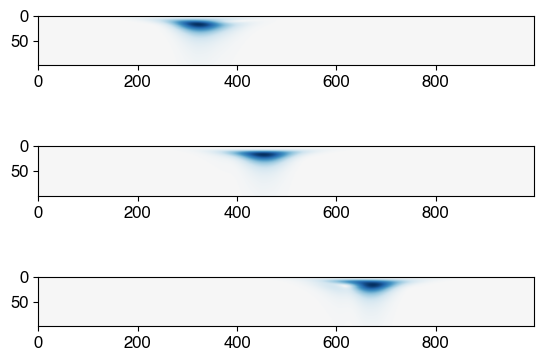

In [29]:
plt.subplot(3,1,1); ldn.imshow(np.abs(cwts_sig[0]))
plt.subplot(3,1,2); ldn.imshow(np.abs(cwts_sig[1]))
plt.subplot(3,1,3); ldn.imshow(np.abs(cwts_sig[2]))

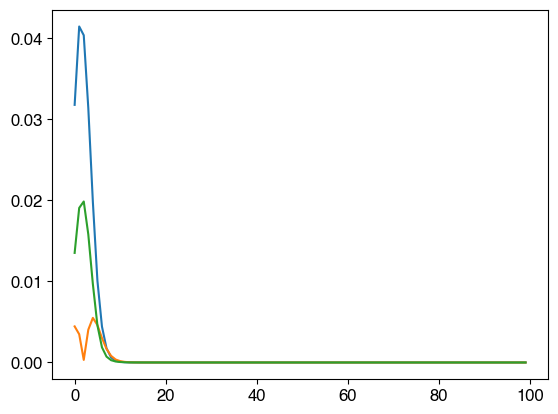

In [30]:
plt.plot(np.abs(cwts_sig[0])[:,ts_sig[0]])
plt.plot(np.abs(cwts_sig[1])[:,ts_sig[1]])
plt.plot(np.abs(cwts_sig[2])[:,ts_sig[2]])

# observation

In [31]:
ctrs = [[(1, 1), (3, 3), (2, 2)],
        [(3, 3), (1, 1), (2, 2)]]
lags = [[0, 30, 30],
        [30, 0, 0]]
ws = [[np.sqrt(0.006), np.sqrt(0.006), np.sqrt(0.006)],
      [np.sqrt(0.006), np.sqrt(0.006), np.sqrt(0.006)]]

In [32]:
betas = [[np.exp(-np.sum((cd-ct)**2,-1)/(2*sig**2))
          for ct in ctr]
         for cd, ctr, sig in zip(coords_S, ctrs, sigmas_S)] 

In [33]:
obss = [eta + w[0] * beta[0] * sigs[0][:,num_rtime//2-lag[0]:-num_rtime//2-lag[0]+1,None]
            + w[1] * beta[1] * sigs[1][:,num_rtime//2-lag[1]:-num_rtime//2-lag[1]+1,None]
            + w[2] * beta[2] * sigs[2][:,num_rtime//2-lag[2]:-num_rtime//2-lag[2]+1,None]
        for eta, beta, lag, w in zip(etas, betas, lags, ws)]

## plot

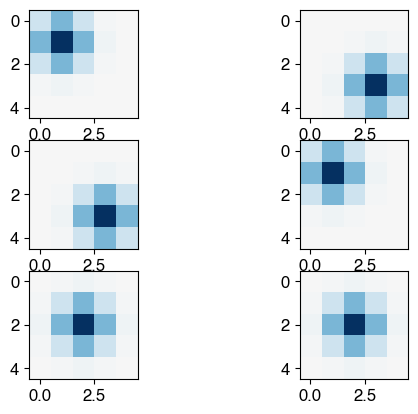

In [34]:
plt.subplot(3,2,1); ldn.imshow(betas[0][0].reshape((5,5)))
plt.subplot(3,2,2); ldn.imshow(betas[1][0].reshape((5,5)))
plt.subplot(3,2,3); ldn.imshow(betas[0][1].reshape((5,5)))
plt.subplot(3,2,4); ldn.imshow(betas[1][1].reshape((5,5)))
plt.subplot(3,2,5); ldn.imshow(betas[0][2].reshape((5,5)))
plt.subplot(3,2,6); ldn.imshow(betas[1][2].reshape((5,5)))

In [35]:
cwt_omega = 3
cwt_scales = cwt_omega * 1000 / (2 * (np.arange(100)+1) * np.pi)

In [36]:
cwt_obs = [np.zeros((d, len(cwt_scales), num_rtime), dtype=np.complex128)
           for d in dims]
for k, d in enumerate(dims):
    for i in np.arange(d):
        cwt_obs[k][i] = signal.cwt(obss[k][0,:,i], signal.morlet2, cwt_scales, w=cwt_omega)

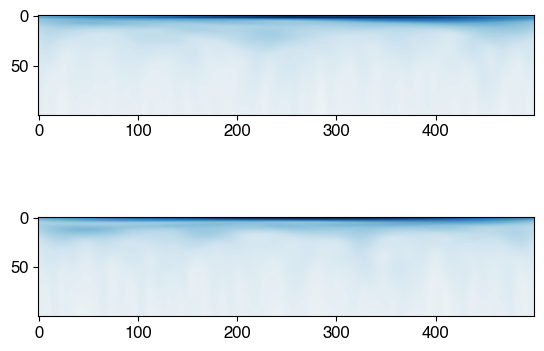

In [37]:
plt.subplot(2,1,1); ldn.imshow(np.mean(np.abs(cwt_obs[0]),0))
plt.subplot(2,1,2); ldn.imshow(np.mean(np.abs(cwt_obs[1]),0))

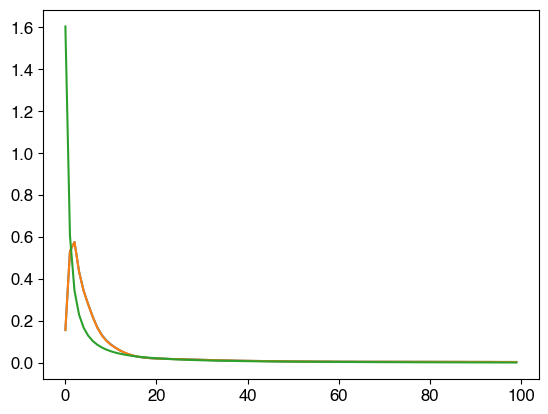

In [38]:
plt.plot(np.mean(np.abs(cwt_obs[0][:,:,400])**2,axis=0))
plt.plot(np.mean(np.abs(cwt_eta_0[0][:,:,400])**2,axis=0))
plt.plot(0.0035 * psd[:100])

# 2. pre-processing

In [39]:
cwt_omega = 3 
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)

In [40]:
filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)

In [41]:
data = [np.zeros((num_rtime//10, d , num_trial)) for d in dims]

In [42]:
for l, d in enumerate(dims):
    for i in np.arange(d):
        data[l][:,i,:] = np.abs(signal.convolve(obss[l][:,:,i], 
                filter_map[None,:], mode='same')[:,::10]).T

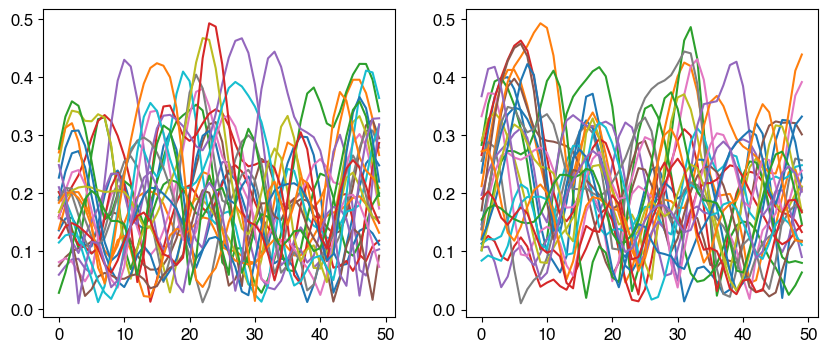

In [43]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.plot(data[0][:,:,0])
plt.subplot(1,2,2); plt.plot(data[1][:,:,0])
plt.show()

In [44]:
noise = [np.zeros((num_rtime//10, d , num_trial)) for d in dims]

In [45]:
for l, d in enumerate(dims):
    for i in np.arange(d):
        noise[l][:,i,:] = np.abs(signal.convolve(etas[l][:,:,i], 
                filter_map[None,:], mode='same')[:,::10]).T

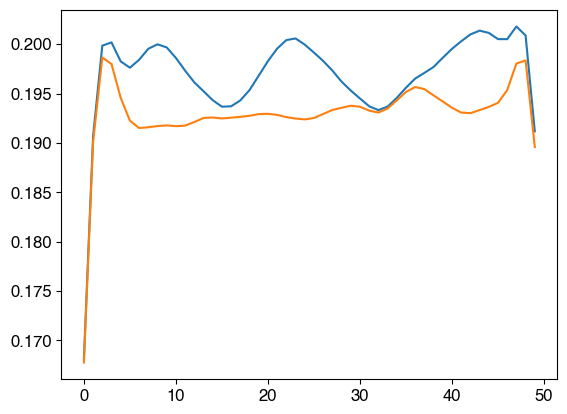

In [46]:
plt.plot(np.mean(data[0], (1,2)))
plt.plot(np.mean(noise[0], (1,2)))

In [47]:
data[0].shape, data[1].shape

((50, 25, 1000), (50, 25, 1000))

In [48]:
io.savemat('data_simulation_10.mat', {'data_0': data[0], 'data_1': data[1]})

# 3. parameter calibration

In [49]:
rec_time = [0, 500]
num_time = data[0].shape[0]

## diagonal regularization

In [50]:
cwt_omega = 3
cwt_scale = cwt_omega * 100 / (2 * f_beta * np.pi)

In [51]:
lambdas_diag = np.array([1, 2, 3, 5, 10, 20, 30, 50, 100, 200])
W_diagmean = np.zeros([len(lambdas_diag), num_time-1])
SW_ratio = np.zeros(len(lambdas_diag))
SW_error = np.zeros(len(lambdas_diag))

In [52]:
filter_mat = np.exp(-0.5*((np.arange(num_time)[:,None]
                          -np.arange(num_time))/cwt_scale)**2)
filter_mat[np.eye(num_time).astype(bool)]=0

In [53]:
for i, l_i in enumerate(lambdas_diag):
    Omegas_bar = np.concatenate([
    np.array([np.linalg.inv(np.corrcoef(dat[:,i,:]) + l_i * np.eye(num_time)) 
              for i in np.arange(d)])
    for d, dat in zip(dims, data)])
    Omegas_bar[np.array([np.eye(num_time).astype(bool)]*np.sum(dims))]=0
    
    W_diagmean[i] = np.array([
        np.mean(np.diagonal(np.mean(Omegas_bar, 0), k))
        for k in np.arange(1,num_time)
    ])
    
    SW_ratio[i] = np.sum(filter_mat*Omegas_bar) / np.sum(Omegas_bar**2)

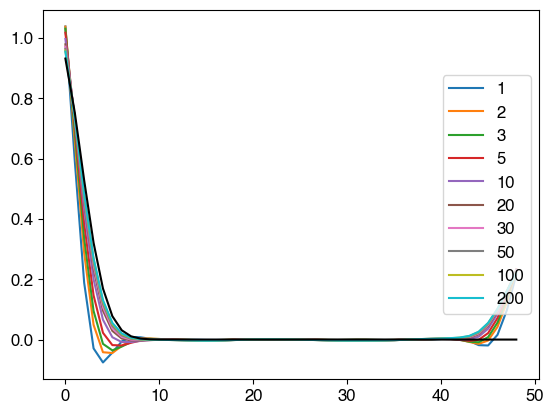

In [54]:
lineObjects = plt.plot(SW_ratio * W_diagmean.T)
plt.plot(np.exp(-0.5*(np.arange(1,num_time)/cwt_scale)**2),
         color='black')
plt.legend(list(lineObjects), lambdas_diag, loc='right')

In [55]:
np.sum((SW_ratio[:,None] * W_diagmean 
 - np.array(
     [np.mean(np.diagonal(filter_mat, k)) 
      for k in np.arange(1,num_time)]))**2, 1)

array([0.40829361, 0.28396363, 0.22744982, 0.17496279, 0.13261657,
       0.11245048, 0.10640526, 0.10200428, 0.09904328, 0.09769674])

## calibration by permutation

In [56]:
offset_cross=10
offset_auto=10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 20), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [57]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [58]:
b_time = np.linspace(rec_time[0], rec_time[1], num_time)
l_time = np.linspace(rec_time[0], rec_time[1], 2*num_time-1)

In [59]:
num_cv = 10

In [60]:
Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
weights_cv = []

for iter_cv in np.arange(num_cv):
    start_cv = time.time()
    
    # random sample
    trial_sample = np.random.choice(num_trial, num_trial, False)
    data_bst = [data[0], data[1][:,:,trial_sample]]

    for iter_est, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
    in enumerate(zip(*lambdas)): 
        if iter_cv > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est],
                        'weight_init': weights_cv[iter_est]}
        elif iter_est > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est-1],
                        'weight_init': weights_cv[iter_est-1]}
        else:
            init_arg = dict()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                   lambda_auto, offset_auto, 
                   ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                   **init_arg)
        
        # save result
        Omegas_cv[iter_cv, iter_est] = Omega_est
        if iter_cv == 0:
            weights_cv.append(weight_est)

    sys.__stdout__.write("%d-th cv finished, lapse: %.3fsec.\n"
                         %(iter_cv+1, time.time()-start_cv))
    sys.__stdout__.flush()

1-th iter, nll: 404.102247, change: 0.183227, lapse: 0.046188
2-th iter, nll: 404.097558, change: 0.041493, lapse: 0.067041
3-th iter, nll: 404.094007, change: 0.027039, lapse: 0.051879
4-th iter, nll: 404.091107, change: 0.023639, lapse: 0.047244
5-th iter, nll: 404.088661, change: 0.021560, lapse: 0.083471
6-th iter, nll: 404.086562, change: 0.020493, lapse: 0.069585
7-th iter, nll: 404.084740, change: 0.018964, lapse: 0.054070
8-th iter, nll: 404.083145, change: 0.017010, lapse: 0.043692
9-th iter, nll: 404.081739, change: 0.014991, lapse: 0.100215
10-th iter, nll: 404.080492, change: 0.012969, lapse: 0.091696
11-th iter, nll: 404.079380, change: 0.011356, lapse: 0.072863
12-th iter, nll: 404.078384, change: 0.010090, lapse: 0.046623
13-th iter, nll: 404.077486, change: 0.009356, lapse: 0.089218
14-th iter, nll: 404.076675, change: 0.008563, lapse: 0.056293
15-th iter, nll: 404.075941, change: 0.007862, lapse: 0.118602
16-th iter, nll: 404.075273, change: 0.007376, lapse: 0.077401
1

5-th iter, nll: 404.067538, change: 0.003831, lapse: 0.083541
6-th iter, nll: 404.067508, change: 0.003276, lapse: 0.066625
7-th iter, nll: 404.067483, change: 0.002848, lapse: 0.096017
8-th iter, nll: 404.067462, change: 0.002498, lapse: 0.079681
9-th iter, nll: 404.067444, change: 0.002205, lapse: 0.065564
10-th iter, nll: 404.067429, change: 0.001957, lapse: 0.045699
11-th iter, nll: 404.067415, change: 0.001746, lapse: 0.060787
12-th iter, nll: 404.067403, change: 0.001565, lapse: 0.065819
13-th iter, nll: 404.067393, change: 0.001410, lapse: 0.084774
14-th iter, nll: 404.067383, change: 0.001275, lapse: 0.088361
15-th iter, nll: 404.067375, change: 0.001157, lapse: 0.076114
16-th iter, nll: 404.067367, change: 0.001053, lapse: 0.075994
17-th iter, nll: 404.067361, change: 0.000961, lapse: 0.071285
1-th iter, nll: 404.067467, change: 0.114559, lapse: 0.075575
2-th iter, nll: 404.067339, change: 0.008203, lapse: 0.072660
3-th iter, nll: 404.067252, change: 0.006473, lapse: 0.047496


5-th iter, nll: 404.068269, change: 0.001849, lapse: 0.059191
6-th iter, nll: 404.068257, change: 0.001527, lapse: 0.073508
7-th iter, nll: 404.068247, change: 0.001286, lapse: 0.071180
8-th iter, nll: 404.068239, change: 0.001099, lapse: 0.060004
9-th iter, nll: 404.068231, change: 0.000950, lapse: 0.068611
1-th iter, nll: 404.068033, change: 0.079825, lapse: 0.084061
2-th iter, nll: 404.067976, change: 0.005592, lapse: 0.081005
3-th iter, nll: 404.067939, change: 0.003696, lapse: 0.083648
4-th iter, nll: 404.067913, change: 0.002841, lapse: 0.059037
5-th iter, nll: 404.067892, change: 0.002264, lapse: 0.052398
6-th iter, nll: 404.067875, change: 0.001844, lapse: 0.068506
7-th iter, nll: 404.067861, change: 0.001542, lapse: 0.070591
8-th iter, nll: 404.067850, change: 0.001322, lapse: 0.071176
9-th iter, nll: 404.067840, change: 0.001148, lapse: 0.085818
10-th iter, nll: 404.067831, change: 0.001007, lapse: 0.066269
11-th iter, nll: 404.067824, change: 0.000891, lapse: 0.061663
1-th i

4-th iter, nll: 404.068051, change: 0.003409, lapse: 0.080197
5-th iter, nll: 404.068033, change: 0.002739, lapse: 0.099625
6-th iter, nll: 404.068018, change: 0.002286, lapse: 0.078650
7-th iter, nll: 404.068007, change: 0.001953, lapse: 0.104762
8-th iter, nll: 404.067997, change: 0.001696, lapse: 0.093563
9-th iter, nll: 404.067988, change: 0.001489, lapse: 0.103795
10-th iter, nll: 404.067981, change: 0.001320, lapse: 0.129937
11-th iter, nll: 404.067974, change: 0.001178, lapse: 0.074872
12-th iter, nll: 404.067969, change: 0.001058, lapse: 0.095773
13-th iter, nll: 404.067964, change: 0.000956, lapse: 0.101555
1-th iter, nll: 404.067934, change: 0.106557, lapse: 0.113942
2-th iter, nll: 404.067859, change: 0.008083, lapse: 0.152065
3-th iter, nll: 404.067810, change: 0.005092, lapse: 0.134601
4-th iter, nll: 404.067776, change: 0.003660, lapse: 0.111020
5-th iter, nll: 404.067751, change: 0.002918, lapse: 0.080496
6-th iter, nll: 404.067730, change: 0.002418, lapse: 0.086804
7-th

2-th iter, nll: 404.068340, change: 0.004653, lapse: 0.081986
3-th iter, nll: 404.068311, change: 0.003786, lapse: 0.048375
4-th iter, nll: 404.068287, change: 0.003165, lapse: 0.072621
5-th iter, nll: 404.068267, change: 0.002762, lapse: 0.059265
6-th iter, nll: 404.068250, change: 0.002424, lapse: 0.082723
7-th iter, nll: 404.068234, change: 0.002137, lapse: 0.062332
8-th iter, nll: 404.068221, change: 0.001908, lapse: 0.060905
9-th iter, nll: 404.068208, change: 0.001712, lapse: 0.060800
10-th iter, nll: 404.068197, change: 0.001550, lapse: 0.056059
11-th iter, nll: 404.068187, change: 0.001433, lapse: 0.062482
12-th iter, nll: 404.068177, change: 0.001329, lapse: 0.061111
13-th iter, nll: 404.068168, change: 0.001236, lapse: 0.060321
14-th iter, nll: 404.068160, change: 0.001154, lapse: 0.089116
15-th iter, nll: 404.068153, change: 0.001080, lapse: 0.054608
16-th iter, nll: 404.068146, change: 0.001014, lapse: 0.091406
17-th iter, nll: 404.068140, change: 0.000953, lapse: 0.056043


15-th iter, nll: 404.066652, change: 0.001447, lapse: 0.118371
16-th iter, nll: 404.066636, change: 0.001342, lapse: 0.115567
17-th iter, nll: 404.066621, change: 0.001247, lapse: 0.087262
18-th iter, nll: 404.066607, change: 0.001177, lapse: 0.108503
19-th iter, nll: 404.066594, change: 0.001123, lapse: 0.057607
20-th iter, nll: 404.066583, change: 0.001071, lapse: 0.076833
21-th iter, nll: 404.066572, change: 0.001023, lapse: 0.061203
22-th iter, nll: 404.066563, change: 0.000978, lapse: 0.076950
1-th iter, nll: 404.067395, change: 0.136007, lapse: 0.098914
2-th iter, nll: 404.067221, change: 0.006912, lapse: 0.083181
3-th iter, nll: 404.067101, change: 0.005649, lapse: 0.080745
4-th iter, nll: 404.067010, change: 0.004801, lapse: 0.083807
5-th iter, nll: 404.066937, change: 0.004201, lapse: 0.107201
6-th iter, nll: 404.066877, change: 0.003712, lapse: 0.069848
7-th iter, nll: 404.066826, change: 0.003269, lapse: 0.146383
8-th iter, nll: 404.066782, change: 0.002873, lapse: 0.083305


12-th iter, nll: 404.066523, change: 0.001425, lapse: 0.049892
13-th iter, nll: 404.066509, change: 0.001335, lapse: 0.093838
14-th iter, nll: 404.066496, change: 0.001256, lapse: 0.071420
15-th iter, nll: 404.066485, change: 0.001185, lapse: 0.078828
16-th iter, nll: 404.066475, change: 0.001120, lapse: 0.075131
17-th iter, nll: 404.066467, change: 0.001059, lapse: 0.065445
18-th iter, nll: 404.066459, change: 0.001003, lapse: 0.095619
19-th iter, nll: 404.066452, change: 0.000950, lapse: 0.062395
1-th iter, nll: 404.067112, change: 0.159410, lapse: 0.062744
2-th iter, nll: 404.066939, change: 0.006152, lapse: 0.066939
3-th iter, nll: 404.066825, change: 0.004090, lapse: 0.066939
4-th iter, nll: 404.066742, change: 0.003276, lapse: 0.050512
5-th iter, nll: 404.066679, change: 0.002800, lapse: 0.071306
6-th iter, nll: 404.066628, change: 0.002440, lapse: 0.057456
7-th iter, nll: 404.066587, change: 0.002180, lapse: 0.075429
8-th iter, nll: 404.066553, change: 0.001978, lapse: 0.063377


24-th iter, nll: 404.066150, change: 0.000969, lapse: 0.068124
1-th iter, nll: 404.066672, change: 0.154735, lapse: 0.064691
2-th iter, nll: 404.066500, change: 0.007100, lapse: 0.082455
3-th iter, nll: 404.066394, change: 0.005155, lapse: 0.069642
4-th iter, nll: 404.066321, change: 0.004147, lapse: 0.088910
5-th iter, nll: 404.066267, change: 0.003363, lapse: 0.077813
6-th iter, nll: 404.066225, change: 0.002930, lapse: 0.040715
7-th iter, nll: 404.066191, change: 0.002603, lapse: 0.076861
8-th iter, nll: 404.066163, change: 0.002387, lapse: 0.062267
9-th iter, nll: 404.066140, change: 0.002206, lapse: 0.055205
10-th iter, nll: 404.066120, change: 0.002052, lapse: 0.048698
11-th iter, nll: 404.066102, change: 0.001918, lapse: 0.060052
12-th iter, nll: 404.066087, change: 0.001799, lapse: 0.078735
13-th iter, nll: 404.066073, change: 0.001692, lapse: 0.088082
14-th iter, nll: 404.066061, change: 0.001596, lapse: 0.056227
15-th iter, nll: 404.066049, change: 0.001508, lapse: 0.068150
1

17-th iter, nll: 404.066848, change: 0.001058, lapse: 0.090721
18-th iter, nll: 404.066843, change: 0.000996, lapse: 0.084388
1-th iter, nll: 404.067040, change: 0.137730, lapse: 0.163755
2-th iter, nll: 404.066902, change: 0.006146, lapse: 0.050770
3-th iter, nll: 404.066813, change: 0.004687, lapse: 0.086923
4-th iter, nll: 404.066749, change: 0.003527, lapse: 0.095624
5-th iter, nll: 404.066701, change: 0.003033, lapse: 0.073104
6-th iter, nll: 404.066664, change: 0.002708, lapse: 0.095384
7-th iter, nll: 404.066634, change: 0.002436, lapse: 0.080183
8-th iter, nll: 404.066609, change: 0.002206, lapse: 0.058662
9-th iter, nll: 404.066589, change: 0.002012, lapse: 0.053781
10-th iter, nll: 404.066571, change: 0.001846, lapse: 0.078478
11-th iter, nll: 404.066556, change: 0.001703, lapse: 0.080432
12-th iter, nll: 404.066543, change: 0.001578, lapse: 0.085917
13-th iter, nll: 404.066531, change: 0.001468, lapse: 0.065139
14-th iter, nll: 404.066521, change: 0.001369, lapse: 0.073415
1

2-th iter, nll: 404.067855, change: 0.005092, lapse: 0.151376
3-th iter, nll: 404.067806, change: 0.003081, lapse: 0.133343
4-th iter, nll: 404.067770, change: 0.002094, lapse: 0.108926
5-th iter, nll: 404.067743, change: 0.001772, lapse: 0.064577
6-th iter, nll: 404.067721, change: 0.001589, lapse: 0.085194
7-th iter, nll: 404.067702, change: 0.001458, lapse: 0.108115
8-th iter, nll: 404.067686, change: 0.001348, lapse: 0.097806
9-th iter, nll: 404.067673, change: 0.001249, lapse: 0.108386
10-th iter, nll: 404.067661, change: 0.001159, lapse: 0.138972
11-th iter, nll: 404.067651, change: 0.001076, lapse: 0.150506
12-th iter, nll: 404.067642, change: 0.001000, lapse: 0.107952
1-th iter, nll: 404.067769, change: 0.129811, lapse: 0.116602
2-th iter, nll: 404.067671, change: 0.005429, lapse: 0.087920
3-th iter, nll: 404.067608, change: 0.003310, lapse: 0.097556
4-th iter, nll: 404.067563, change: 0.002252, lapse: 0.094696
5-th iter, nll: 404.067529, change: 0.001934, lapse: 0.102073
6-th 

1-th iter, nll: 404.067339, change: 0.139809, lapse: 0.109488
2-th iter, nll: 404.067214, change: 0.006060, lapse: 0.071846
3-th iter, nll: 404.067133, change: 0.003779, lapse: 0.066997
4-th iter, nll: 404.067075, change: 0.002741, lapse: 0.107423
5-th iter, nll: 404.067031, change: 0.002153, lapse: 0.044307
6-th iter, nll: 404.066996, change: 0.001769, lapse: 0.065494
7-th iter, nll: 404.066967, change: 0.001490, lapse: 0.058629
8-th iter, nll: 404.066944, change: 0.001272, lapse: 0.078241
9-th iter, nll: 404.066924, change: 0.001098, lapse: 0.049438
10-th iter, nll: 404.066907, change: 0.000996, lapse: 0.064255
1-th iter, nll: 404.067254, change: 0.142689, lapse: 0.074203
2-th iter, nll: 404.067116, change: 0.006188, lapse: 0.083917
3-th iter, nll: 404.067027, change: 0.003921, lapse: 0.059320
4-th iter, nll: 404.066963, change: 0.002847, lapse: 0.070328
5-th iter, nll: 404.066914, change: 0.002235, lapse: 0.050758
6-th iter, nll: 404.066875, change: 0.001836, lapse: 0.075024
7-th it

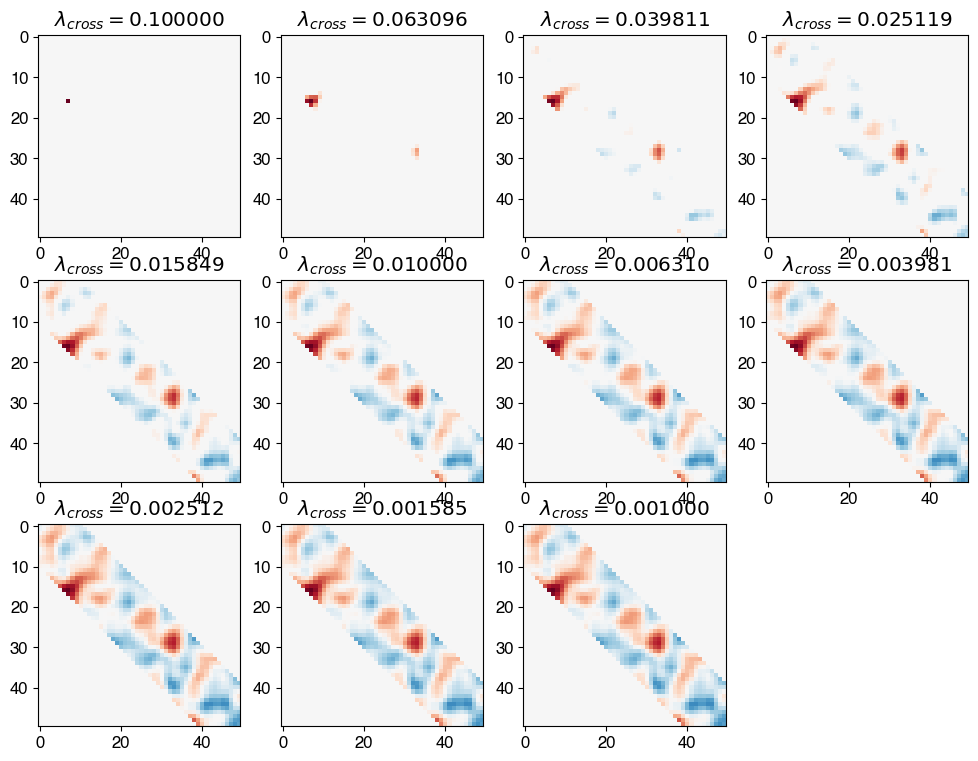

In [61]:
plt.figure(figsize=(12,3*int(lambdas.shape[-1]/4+1)))
for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
in enumerate(zip(*lambdas)):
    plt.subplot(int(lambdas.shape[-1]/4+1), 4, iter_lambda+1)
    ldn.imshow(Omegas_cv[0, iter_lambda,:num_time,num_time:], identity=True)
    plt.title(r'$\lambda_{cross} = %f$'%lambda_cross)

In [62]:
fds_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/num_cv
fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv

Text(0, 0.5, 'mean false discovery')

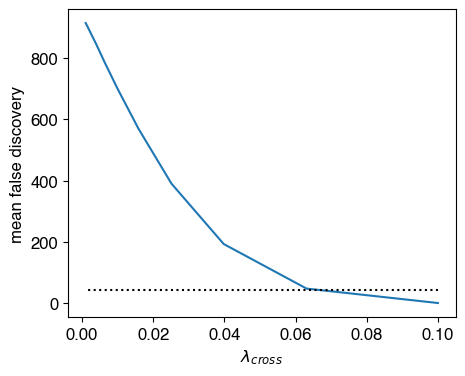

In [63]:
plt.figure(figsize=(5,4))
plt.plot(lambdas[0], fds_cv)
plt.plot(lambdas[0], np.full(lambdas[0].shape, 0.05*np.sum(time_graph_cross)), color='black', linestyle=':')
plt.xlabel(r"$\lambda_{cross}$")
plt.ylabel(r"mean false discovery")

In [64]:
id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])

In [65]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.10000000000000002, 0.0, 20.0, 0.0)

In [66]:
# lambda_cross, lambda_auto, lambda_diag, lambda_ridge = (0.02, 0, 1, 0) 

# 4. LaDynS

In [67]:
lambda_graph = np.array(np.block(
    [[(1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time), (1+lambda_cross)*time_graph_cross],
     [(1+lambda_cross)*time_graph_cross, (1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time)]])) -1

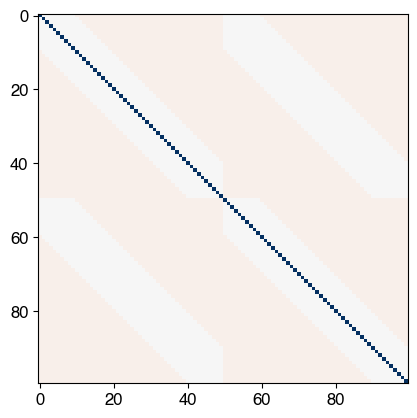

In [68]:
ldn.imshow(lambda_graph)

In [69]:
S_xt = np.cov(*[dat.transpose([1,0,2]).reshape([d,-1])
                for dat, d in zip(data, dims)])
S_1 = S_xt[:dims[0],:dims[0]]
S_12 = S_xt[:dims[0],dims[0]:]
S_2 = S_xt[dims[0]:,dims[0]:]

U_1= linalg.inv(linalg.sqrtm(S_1))
U_2 = linalg.inv(linalg.sqrtm(S_2))

u, s, vh = np.linalg.svd(U_1 @ S_12 @ U_2)
weight_init = [(U_1 @ u[:,0]).copy() for _ in np.arange(num_time)] \
            + [ (U_2 @ vh[0]).copy() for _ in np.arange(num_time)]

In [70]:
Omega_est, Sigma_est, latent_est, weight_est =\
    ldn.fit(data, lambda_diag, lambda_cross, offset_cross,
            lambda_auto, offset_auto, 
            ths_glasso=1e-6, ths_lasso=1e-6, verbose=True)

1-th iter, nll: 404.102246, change: 0.183227, lapse: 0.073830
2-th iter, nll: 404.097558, change: 0.041493, lapse: 0.083498
3-th iter, nll: 404.094007, change: 0.027039, lapse: 0.049737
4-th iter, nll: 404.091107, change: 0.023639, lapse: 0.062760
5-th iter, nll: 404.088658, change: 0.021560, lapse: 0.087378
6-th iter, nll: 404.086542, change: 0.020493, lapse: 0.067930
7-th iter, nll: 404.084687, change: 0.018965, lapse: 0.060242
8-th iter, nll: 404.083040, change: 0.017013, lapse: 0.163468
9-th iter, nll: 404.081564, change: 0.015014, lapse: 0.073149
10-th iter, nll: 404.080231, change: 0.013975, lapse: 0.059956
11-th iter, nll: 404.079014, change: 0.014048, lapse: 0.051581
12-th iter, nll: 404.077896, change: 0.014062, lapse: 0.082793
13-th iter, nll: 404.076865, change: 0.013795, lapse: 0.048932
14-th iter, nll: 404.075910, change: 0.013307, lapse: 0.096433
15-th iter, nll: 404.075027, change: 0.012595, lapse: 0.053325
16-th iter, nll: 404.074212, change: 0.011770, lapse: 0.070856
1

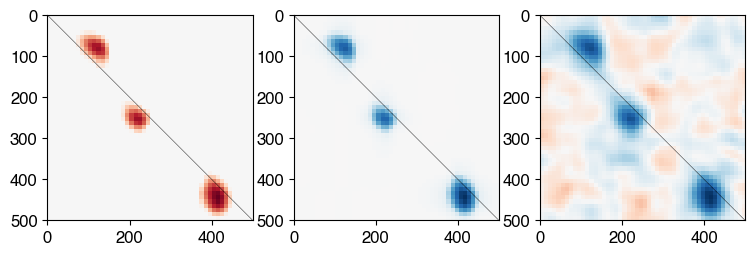

In [71]:
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); ldn.imshow(Omega_est[:num_time,num_time:], time=rec_time, identity=True)
plt.subplot(1,3,2); ldn.imshow(linalg.inv(Omega_est)[:num_time,num_time:], time=rec_time, identity=True)
plt.subplot(1,3,3); ldn.imshow(Sigma_est[:num_time,num_time:], time=rec_time, identity=True)

In [72]:
dspr_est = 2*Omega_est - Omega_est @ (Sigma_est + lambda_diag*np.eye(2*num_time)) @ Omega_est

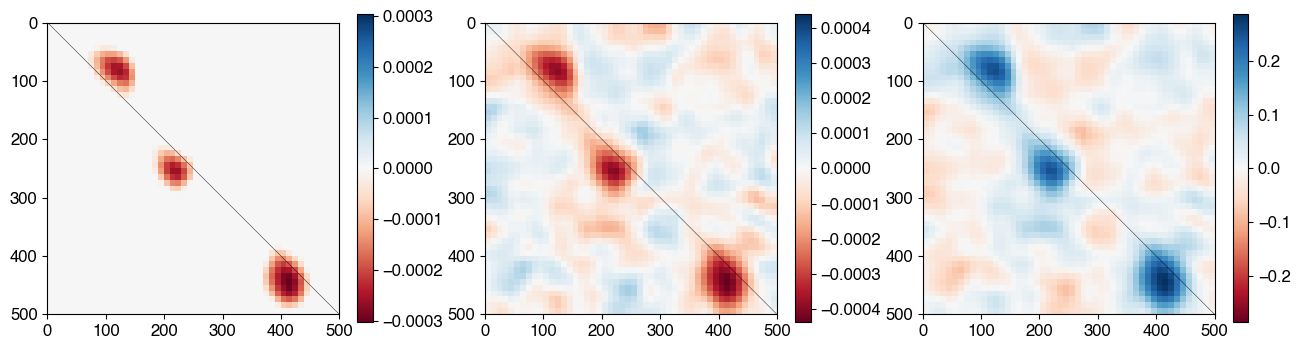

In [73]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); ldn.imshow(Omega_est[:num_time, num_time:], time=rec_time, identity=True); plt.colorbar()
plt.subplot(1,3,2); ldn.imshow(dspr_est[:num_time, num_time:], time=rec_time, identity=True); plt.colorbar()
plt.subplot(1,3,3); ldn.imshow(Sigma_est[:num_time, num_time:], time=rec_time, identity=True); plt.colorbar()

# 5. Permutation test

In [74]:
num_perm = 200

In [75]:
init_arg = {'Omega_init': Omegas_cv[0,id_cv],
            'weight_init': weights_cv[id_cv]}

In [76]:
Omegas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])
Sigmas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])

for iter_perm in range(num_perm):    
    while True:
        with np.errstate(all='raise'):
            try:
                start_perm = time.time()
                
                # random sample
                trial_sample = np.random.choice(num_trial, num_trial, False)
                data_bst = [data[0], data[1][:,:,trial_sample]]

                # permutation
                Omega_perm, Sigma_perm, latent_perm, weight_perm \
                = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                          lambda_auto, offset_auto, 
                          ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                          **init_arg)
        
                
            except FloatingPointError:
                sys.__stdout__.write("%d-th permutation encountered FloatingPointError, lapse:%.3fsec.\n"
                                     %(iter_perm+1, time.time()-start_perm))
                sys.__stdout__.write("Retrying...\n")
                sys.__stdout__.flush()
                continue
                
            init_arg = {'Omega_init':Omega_perm, 'weight_init':weight_perm}
                        
            # save result
            Omegas_perm[iter_perm] = Omega_perm
            Sigmas_perm[iter_perm] = Sigma_perm
            
            sys.__stdout__.write("%d-th permutation finished, lapse: %.3fsec.\n"
                          %(iter_perm+1, time.time()-start_perm))
            sys.__stdout__.flush()
            break

1-th iter, nll: 404.068835, change: 0.001557, lapse: 0.093965
2-th iter, nll: 404.068817, change: 0.000865, lapse: 0.084397
1-th permutation finished, lapse: 0.186sec.
1-th iter, nll: 404.068802, change: 0.000824, lapse: 0.073010
2-th permutation finished, lapse: 0.083sec.
1-th iter, nll: 404.068787, change: 0.000785, lapse: 0.096412
3-th permutation finished, lapse: 0.103sec.
1-th iter, nll: 404.068773, change: 0.001493, lapse: 0.077422
2-th iter, nll: 404.068761, change: 0.000713, lapse: 0.058891
4-th permutation finished, lapse: 0.145sec.
1-th iter, nll: 404.068749, change: 0.004805, lapse: 0.141554
2-th iter, nll: 404.068738, change: 0.000647, lapse: 0.065754
5-th permutation finished, lapse: 0.214sec.
1-th iter, nll: 404.068728, change: 0.004865, lapse: 0.075009
2-th iter, nll: 404.068719, change: 0.000588, lapse: 0.092791
6-th permutation finished, lapse: 0.177sec.
1-th iter, nll: 404.068711, change: 0.000560, lapse: 0.047503
7-th permutation finished, lapse: 0.059sec.
1-th iter,

1-th iter, nll: 404.068585, change: 0.000053, lapse: 0.079875
63-th permutation finished, lapse: 0.095sec.
1-th iter, nll: 404.068585, change: 0.000050, lapse: 0.070690
64-th permutation finished, lapse: 0.086sec.
1-th iter, nll: 404.068584, change: 0.004675, lapse: 0.183029
2-th iter, nll: 404.068584, change: 0.000084, lapse: 0.108818
65-th permutation finished, lapse: 0.311sec.
1-th iter, nll: 404.068584, change: 0.004759, lapse: 0.097537
2-th iter, nll: 404.068584, change: 0.000045, lapse: 0.065765
66-th permutation finished, lapse: 0.180sec.
1-th iter, nll: 404.068584, change: 0.000044, lapse: 0.064072
67-th permutation finished, lapse: 0.071sec.
1-th iter, nll: 404.068584, change: 0.000043, lapse: 0.054990
68-th permutation finished, lapse: 0.067sec.
1-th iter, nll: 404.068584, change: 0.009914, lapse: 0.083962
2-th iter, nll: 404.068583, change: 0.000311, lapse: 0.114054
69-th permutation finished, lapse: 0.214sec.
1-th iter, nll: 404.068584, change: 0.010208, lapse: 0.060982
2-t

1-th iter, nll: 404.068583, change: 0.000012, lapse: 0.073511
126-th permutation finished, lapse: 0.087sec.
1-th iter, nll: 404.068583, change: 0.000011, lapse: 0.075402
127-th permutation finished, lapse: 0.087sec.
1-th iter, nll: 404.068583, change: 0.000011, lapse: 0.142393
128-th permutation finished, lapse: 0.160sec.
1-th iter, nll: 404.068583, change: 0.000010, lapse: 0.083400
129-th permutation finished, lapse: 0.107sec.
1-th iter, nll: 404.068583, change: 0.007784, lapse: 0.095384
2-th iter, nll: 404.068583, change: 0.000121, lapse: 0.080565
130-th permutation finished, lapse: 0.196sec.
1-th iter, nll: 404.068583, change: 0.007905, lapse: 0.082166
2-th iter, nll: 404.068583, change: 0.000033, lapse: 0.082463
131-th permutation finished, lapse: 0.175sec.
1-th iter, nll: 404.068583, change: 0.000008, lapse: 0.057876
132-th permutation finished, lapse: 0.070sec.
1-th iter, nll: 404.068583, change: 0.005241, lapse: 0.078110
2-th iter, nll: 404.068583, change: 0.000070, lapse: 0.086

2-th iter, nll: 404.068583, change: 0.000028, lapse: 0.115240
183-th permutation finished, lapse: 0.228sec.
1-th iter, nll: 404.068583, change: 0.000006, lapse: 0.083319
184-th permutation finished, lapse: 0.104sec.
1-th iter, nll: 404.068583, change: 0.000005, lapse: 0.097009
185-th permutation finished, lapse: 0.113sec.
1-th iter, nll: 404.068583, change: 0.000005, lapse: 0.115456
186-th permutation finished, lapse: 0.124sec.
1-th iter, nll: 404.068583, change: 0.000004, lapse: 0.059037
187-th permutation finished, lapse: 0.076sec.
1-th iter, nll: 404.068583, change: 0.000004, lapse: 0.068780
188-th permutation finished, lapse: 0.082sec.
1-th iter, nll: 404.068583, change: 0.000003, lapse: 0.059923
189-th permutation finished, lapse: 0.073sec.
1-th iter, nll: 404.068583, change: 0.000003, lapse: 0.089972
190-th permutation finished, lapse: 0.102sec.
1-th iter, nll: 404.068583, change: 0.000003, lapse: 0.040375
191-th permutation finished, lapse: 0.050sec.
1-th iter, nll: 404.068583, 

# 6. FDR inference on Cross-precision

In [77]:
alpha = 0.05
roi = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [78]:
dspr_est = 2*Omega_est - Omega_est@(Sigma_est + lambda_diag*np.eye(2*num_time))@Omega_est
dsprs_perm = 2*Omegas_perm - Omegas_perm@(Sigmas_perm + lambda_diag*np.eye(2*num_time))@Omegas_perm

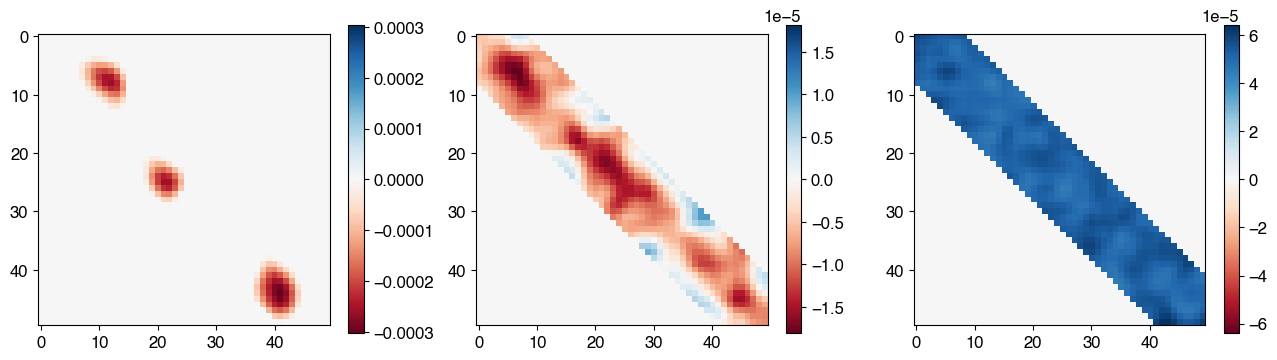

In [79]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); ldn.imshow(Omega_est[:num_time,num_time:]*roi); plt.colorbar()
plt.subplot(1,3,2); ldn.imshow(np.mean(dsprs_perm, 0)[:num_time,num_time:]*roi); plt.colorbar()
plt.subplot(1,3,3); ldn.imshow(np.std(dsprs_perm, 0)[:num_time,num_time:]*roi); plt.colorbar()

In [80]:
dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                 / np.std(dsprs_perm[:,:num_time,num_time:],0))

In [81]:
temp = np.argsort(np.concatenate([
    np.abs(dist_dspr_est[roi]),
    np.abs(dist_dspr_perm[:,roi]).flatten()]))

ranks = np.empty_like(temp)
ranks[temp] = np.cumsum(temp > np.sum(roi))

In [82]:
pval_est = np.full(dist_dspr_est.shape, 0.5)
pvals_perm = np.full(dist_dspr_perm.shape, 0.5)
pval_est[roi] = 1-(ranks[:np.sum(roi)]/len(temp) - 1/(2*len(temp)))
pvals_perm[:,roi] = 1-(ranks[np.sum(roi):].reshape((num_perm,np.sum(roi)))/len(temp) - 1/(2*len(temp)))

In [83]:
pval_est[roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est[roi])), 1e-10, 1-1e-10)

In [84]:
p_sorted = np.concatenate([[0], np.sort(pval_est[roi])])
k_hat = np.max(np.where(np.linspace(0, alpha, np.sum(roi)+1) >= p_sorted))        
rej_BH = pval_est <= k_hat * alpha / np.sum(roi)

## excursion test

In [85]:
ths_nv = k_hat * alpha / np.sum(roi)

In [86]:
rej_nv = pval_est <= ths_nv
rejs_nv_perm = pvals_perm < ths_nv

In [87]:
rejs_blobs_perm = np.zeros((num_perm, num_time, num_time))
nums_blobs_perm = np.zeros((num_perm,))

for iter_perm in range(num_perm):
    mask_cp = rejs_nv_perm[iter_perm]; iter_blob = 0
    while np.any(mask_cp):
        iter_blob += 1
        queue = [tuple(np.transpose(np.where(mask_cp))[0])]
        mask_cp[queue[0]] = False
        while len(queue) > 0:
            cur = queue.pop(0)
            rejs_blobs_perm[iter_perm, cur[0], cur[1]] = iter_blob
            if cur[0] > 0:
                if mask_cp[cur[0]-1, cur[1]]:
                    queue.append((cur[0]-1, cur[1]))
                    mask_cp[cur[0]-1, cur[1]] = False
            if cur[0] < num_time-1:
                if mask_cp[cur[0]+1, cur[1]]:
                    queue.append((cur[0]+1, cur[1]))
                    mask_cp[cur[0]+1, cur[1]] = False
            if cur[1] > 0:
                if mask_cp[cur[0], cur[1]-1]:
                    queue.append((cur[0], cur[1]-1))
                    mask_cp[cur[0], cur[1]-1] = False
            if cur[1] < num_time-1:
                if mask_cp[cur[0], cur[1]+1]:
                    queue.append((cur[0], cur[1]+1))
                    mask_cp[cur[0], cur[1]+1] = False
    nums_blobs_perm[iter_perm] = iter_blob

In [88]:
mrois_nv_perm = np.zeros(num_perm)
for iter_perm, (pval, rej_b, num_b) \
in enumerate(zip(pvals_perm, rejs_blobs_perm, nums_blobs_perm)):
    rois = np.zeros(int(num_b+1))
    for iter_blob in range(1, int(num_b+1)):
        rois[iter_blob] = np.sum(-np.log(
            pvals_perm[iter_perm][rej_b == iter_blob]))
    mrois_nv_perm[iter_perm] = np.max(rois)

In [89]:
ths_roi = np.quantile(mrois_nv_perm, 0.95)

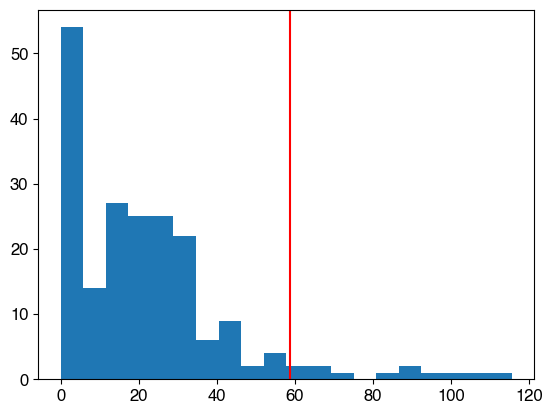

In [90]:
plt.hist(mrois_nv_perm, bins=20)
plt.axvline(x=ths_roi, color='red')

In [91]:
rej_blobs = np.zeros((num_time, num_time))

mask_cp = rej_nv; iter_blob = 0
while np.any(mask_cp):
    iter_blob += 1
    queue = [tuple(np.transpose(np.where(mask_cp))[0])]
    mask_cp[queue[0]] = False
    while len(queue) > 0:
        cur = queue.pop(0)
        rej_blobs[cur[0], cur[1]] = iter_blob
        if cur[0] > 0:
            if mask_cp[cur[0]-1, cur[1]]:
                queue.append((cur[0]-1, cur[1]))
                mask_cp[cur[0]-1, cur[1]] = False
        if cur[0] < num_time-1:
            if mask_cp[cur[0]+1, cur[1]]:
                queue.append((cur[0]+1, cur[1]))
                mask_cp[cur[0]+1, cur[1]] = False
        if cur[1] > 0:
            if mask_cp[cur[0], cur[1]-1]:
                queue.append((cur[0], cur[1]-1))
                mask_cp[cur[0], cur[1]-1] = False
        if cur[1] < num_time-1:
            if mask_cp[cur[0], cur[1]+1]:
                queue.append((cur[0], cur[1]+1))
                mask_cp[cur[0], cur[1]+1] = False
num_blobs = iter_blob

In [92]:
rois_nv = np.zeros(num_blobs+1)
for iter_blob in range(1, num_blobs+1):
    rois_nv[iter_blob] = np.sum(-np.log(pval_est[rej_blobs == iter_blob]))

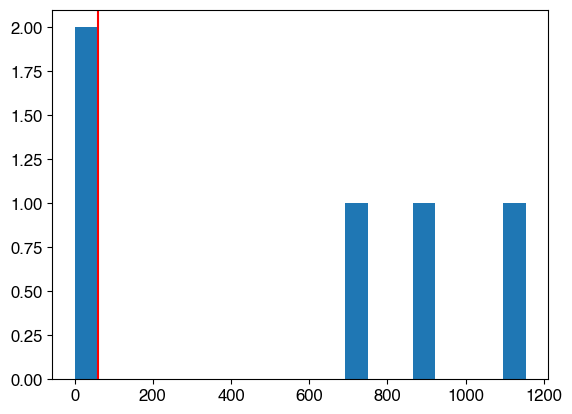

In [93]:
plt.hist(rois_nv, bins=20)
plt.axvline(x=ths_roi, color='red')

In [94]:
np.mean(rois_nv <= mrois_nv_perm[:,None], 0)

array([1.   , 0.   , 0.535, 0.   , 0.   ])

## plots

[]

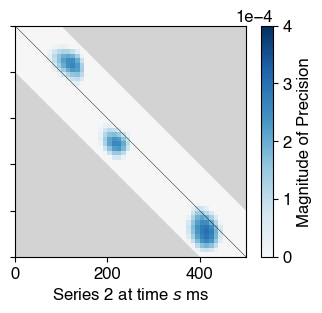

In [95]:
fig, ax = plt.subplots(figsize=(4,3))
ldn.imshow(np.abs(Omega_est[:num_time,num_time:]), time=rec_time, identity=True, 
           vmax=0.0004, cmap='RdBu')

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

cbar = plt.colorbar()
cbar.ax.set_ylim(0, 0.0004); cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_ylabel('Magnitude of Precision')

ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
plt.xlabel(r"Series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$ ms")
plt.yticks([0, 100, 200, 300, 400, 500],['','','','','',''])
plt.plot()

Text(0, 0.5, 'Series 1 at time $t$ ms')

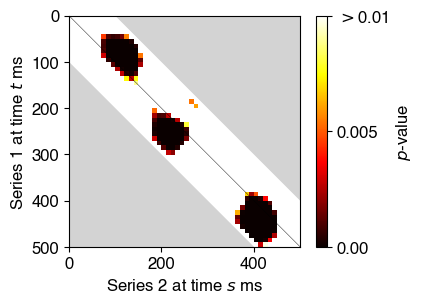

In [96]:
plt.figure(figsize=(4,3))
ldn.imshow(pval_est, cmap='hot', vmin=0, vmax=0.01, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

cbar = plt.colorbar(ticks=[0, 0.005, 0.01])
cbar.ax.set_yticklabels(['0.00','0.005', '$>$0.01'])
cbar.ax.set_ylabel('$p$-value')
plt.xlabel(r"Series 2 at time $s$ ms"); plt.ylabel(r"Series 1 at time $t$ ms")

In [97]:
# fig, ax = plt.subplots(figsize=(4, 3))
# ldn.imshow(rej_BH * np.abs(dspr_est[:num_time,num_time:]), time=rec_time, identity=True, vmax=0.0004)

# ax.fill_between((b_time[offset_cross], rec_time[1]), 
#                 (rec_time[0], rec_time[0]), 
#                 (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
# ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
#                 (b_time[offset_cross], rec_time[1]), 
#                 (rec_time[1], rec_time[1]), color='lightgray')

# cbar = plt.colorbar()
# cbar.ax.set_ylim(0, 0.0004); cbar.formatter.set_powerlimits((0, 0))
# cbar.ax.set_ylabel('Magnitude of Association')

# ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
# plt.xlabel(r"series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$ ms")
# plt.yticks([0, 100, 200, 300, 400, 500],['','','','','',''])
# plt.plot()

[]

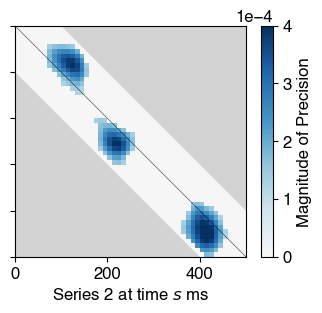

In [98]:
plt.figure(figsize=(4,3))
ldn.imshow(np.abs(dspr_est[:num_time,num_time:]) * np.isin(rej_blobs, np.where(rois_nv > ths_roi)[0]),
           time=rec_time, identity=True, vmax=0.0004, cmap='RdBu')
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])

cbar = plt.colorbar()
cbar.ax.set_ylim(0, 0.0004); cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_ylabel('Magnitude of Precision')

ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
plt.xlabel(r"Series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$ ms")
plt.yticks([0, 100, 200, 300, 400, 500],['','','','','',''])
plt.plot()

In [99]:
np.savez("result_simulation_10",
         Omega_est=Omega_est, Sigma_est=Sigma_est,
         Omegas_perm=Omegas_perm, Sigmas_perm=Sigmas_perm)

# 7. Factor Loading Animation

In [100]:
covs = [[np.cov(da) for da in dat] for dat in data]

In [101]:
loadings = [
    np.matmul(covs[0],np.reshape(weight_est[:num_time], (num_time,-1,1)))[...,0],
    np.matmul(covs[1],np.reshape(weight_est[num_time:], (num_time,-1,1)))[...,0]
]

In [102]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

In [103]:
sigma = 0.5
weights = np.exp(-np.sum(np.square(
    np.mgrid[0:4:100j,0:4:100j][...,None]-coords_S[0].T[:,None,None,:]),
    0) / (2*sigma**2))

Text(0.5, 0, 't = 0.000sec.')

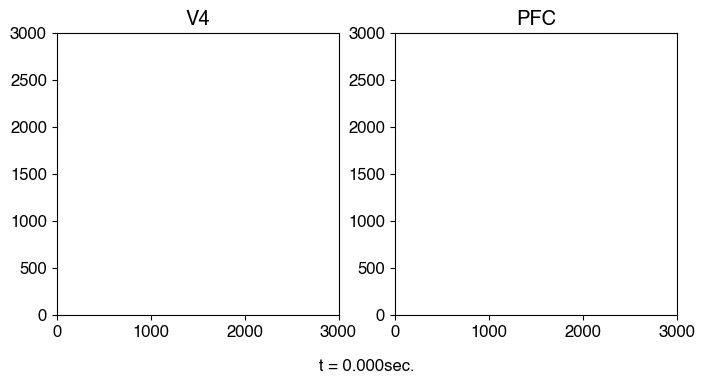

In [104]:
# First set up the figure, the axis, and the plot element we want to animate
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

ax1.set_title("V4"); ax2.set_title("PFC")
img1 = ax1.imshow([[]], cmap='RdBu', origin='lower', extent=((0,3000,0,3000)))
img2 = ax2.imshow([[]], cmap='RdBu', origin='lower', extent=((0,3000,0,3000)))

ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("t = %.3fsec."%0)

In [105]:
# initialization function: plot the background of each frame
def init():
    img1.set_data([[]]); img1.set_clim(-0.1,0.1)
    img2.set_data([[]]); img2.set_clim(-0.1,0.1)
    return (img1,img2)

In [106]:
# animation function. This is called sequentially
def animate(i):
    n = 0
    img1.set_data((np.sum(weights*loadings[0][i],-1)/np.sum(weights,-1)).T)
    img2.set_data((np.sum(weights*loadings[1][i],-1)/np.sum(weights,-1)).T)
    ax3.set_xlabel(r't=%.3fsec.'%((i-1)/100))
    return (img1,img2)

In [107]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=50, interval=100, blit=True)

In [108]:
HTML(anim.to_html5_video())

In [109]:
fmt = {0.25: '.25', 0.5: '.50', 0.75: '.75'}

[Text(1, 0.0, '0'),
 Text(1, 0.25, '.25'),
 Text(1, 0.5, '.50'),
 Text(1, 0.75, '.75'),
 Text(1, 1.0, '1')]

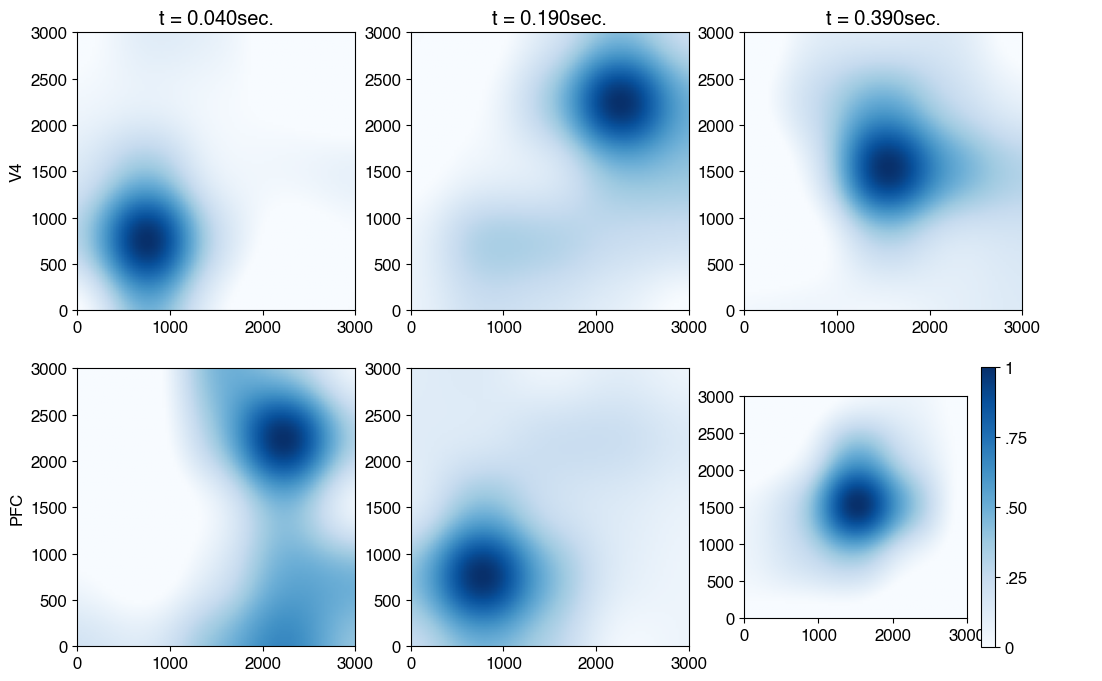

In [110]:
fig, (axes1, axes2) = plt.subplots(2, 3, figsize=(14,8))
tpts = [5, 20, 40]

for i, t in enumerate(tpts):
    (ax1,ax2) = (axes1[i], axes2[i])
    
    ax1.set_title("t = %.3fsec."%((t-1)/100))
    load_norm = [np.sum(weights*loading[t],-1)/np.sum(weights,-1)
                 for loading in loadings]
    zl = [(load/np.max(load)).T for load in load_norm]
    img1 = ax1.imshow(zl[0],
                      cmap='Blues', origin='lower', extent=((0,3000,0,3000)))
    img2 = ax2.imshow(zl[1],
                      cmap='Blues', origin='lower', extent=((0,3000,0,3000)))
    img1.set_clim(0,1)
    img2.set_clim(0,1)
    
#     ct1 = ax1.contour((np.arange(100)+0.5)*30, (np.arange(100)+0.5)*30,
#             zl[0], levels=[0.25, 0.5, 0.75], linewidths=0.2, colors=['black'])
#     ax1.clabel(ct1, ct1.levels, fmt=fmt, inline=True, fontsize=10)
#     ct2 = ax2.contour((np.arange(100)+0.5)*30, (np.arange(100)+0.5)*30,
#             zl[1],  levels=[0.25, 0.5, 0.75], linewidths=0.2, colors=['black'])
#     ax2.clabel(ct2, ct2.levels, fmt=fmt, inline=True, fontsize=10)
    
    if i == 0:
        ax1.set_ylabel("V4")
        ax2.set_ylabel("PFC")
        
fig.subplots_adjust(right=0.8)

ax_cb = fig.add_axes([0.75, 0.15, 0.1, 0.7])
ax_cb.axis('off')
cb = plt.colorbar(ax2.get_images()[0], ticks=[0, 0.25, 0.5, 0.75, 1])
cb.ax.set_yticklabels(['0','.25','.50','.75','1'])

# 8. Granger Causality

In [111]:
bw = 10
order = 5
lambda_reg = lambda_diag # 1.5
lags_cond = np.array([1,2])

In [112]:
GC_ar = np.zeros([num_time, 2])

In [113]:
for end_time in np.arange(bw, num_time):
    Sigma_tw = (Sigma_est.reshape([2,num_time,2,num_time])
        [:,end_time-bw:end_time,:,end_time-bw:end_time])

    Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
        for i in np.arange(bw-order)], 0).reshape((2*order,2*order))
    
    id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
    id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
    id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
    id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])
    
    lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
    lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
    lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
    lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]
    
    lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
    lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
    lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
    lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

    mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
    mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

    mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
    mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]
    
    GC_ar[end_time] = (np.log(mse_ar1) - np.log(mse_ar12), 
                       np.log(mse_ar2) - np.log(mse_ar21))

## permutation bootstrap

In [114]:
num_perm = Sigmas_perm.shape[0]
GCs_perm = np.zeros([num_perm, num_time, 2])

In [115]:
for iter_perm in np.arange(num_perm):
    for end_time in np.arange(bw, num_time):
        Sigma_tw = (Sigmas_perm[iter_perm].reshape([2,num_time,2,num_time])
            [:,end_time-bw:end_time,:,end_time-bw:end_time])

        Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
            for i in np.arange(bw-order)], 0).reshape((2*order,2*order))

        id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
        id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
        id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
        id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])

        lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
        lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
        lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
        lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]

        lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
        lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
        lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
        lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

        mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
        mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

        mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
        mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]

        GCs_perm[iter_perm,end_time] = \
            (np.log(mse_ar1) - np.log(mse_ar12), 
             np.log(mse_ar2) - np.log(mse_ar21))

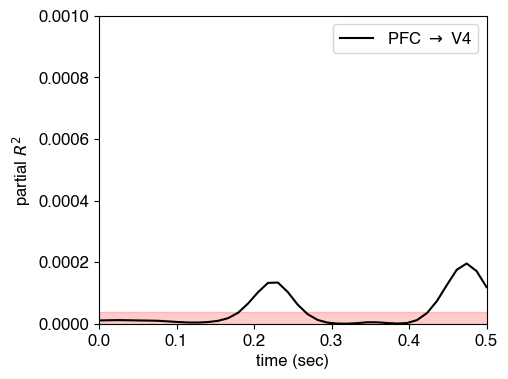

In [116]:
plt.figure(figsize=(5,4))
plt.plot(np.linspace(0,0.5,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,0], label=r'PFC $\rightarrow$ V4', color='black')
plt.fill_between(
    np.linspace(0,0.5,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(np.max(GCs_perm[:,bw:,1],0),0.99,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.001); plt.xlim(0, 0.5)
plt.ylabel(r"partial $R^2$"); plt.xlabel("time (sec)"); plt.legend()
# plt.title(r"Granger Causality from PFC to V4")

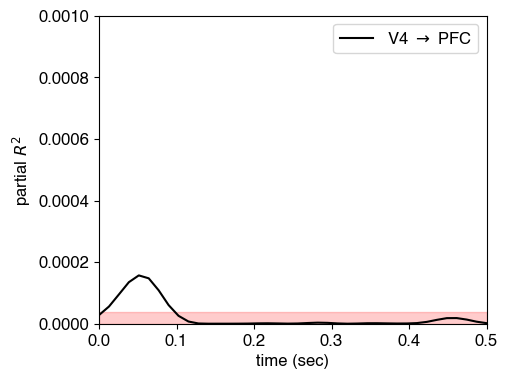

In [117]:
plt.figure(figsize=(5,4))
plt.plot(np.linspace(0,0.5,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,1], label=r'V4 $\rightarrow$ PFC', color='black')
plt.fill_between(
    np.linspace(0,0.5,num_time-bw),
    # np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(np.max(GCs_perm[:,bw:,1],0),0.99,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.001); plt.xlim(0, 0.5)
plt.ylabel(r"partial $R^2$"); plt.xlabel("time (sec)"); plt.legend()
# plt.title(r"Granger Causality from V4 to PFC")

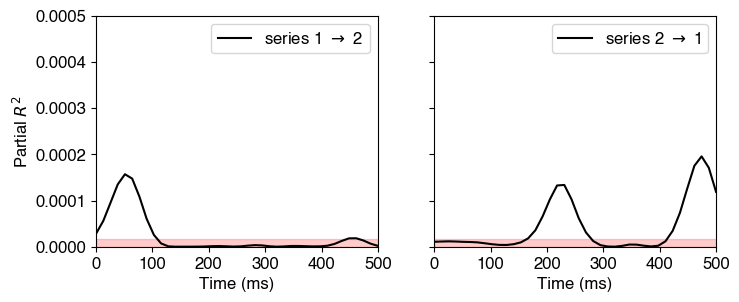

In [118]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,1], label=r'series 1 $\rightarrow$ 2', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(np.max(GCs_perm[:,bw:,0],1),0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.0005); plt.xlim(0, 500)
plt.ylabel(r"Partial $R^2$"); plt.xlabel("Time (ms)"); plt.legend()
# plt.title(r"Granger Causality from PFC to V4")

plt.subplot(1,2,2)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,0], label=r'series 2 $\rightarrow$ 1', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw),
    # np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(np.max(GCs_perm[:,bw:,1],1),0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.0005); plt.xlim(0, 500)
plt.ylabel(r""); plt.xlabel("Time (ms)"); plt.legend()
plt.tick_params('y', labelleft=False)